# LangChain Expression Language (LCEL)

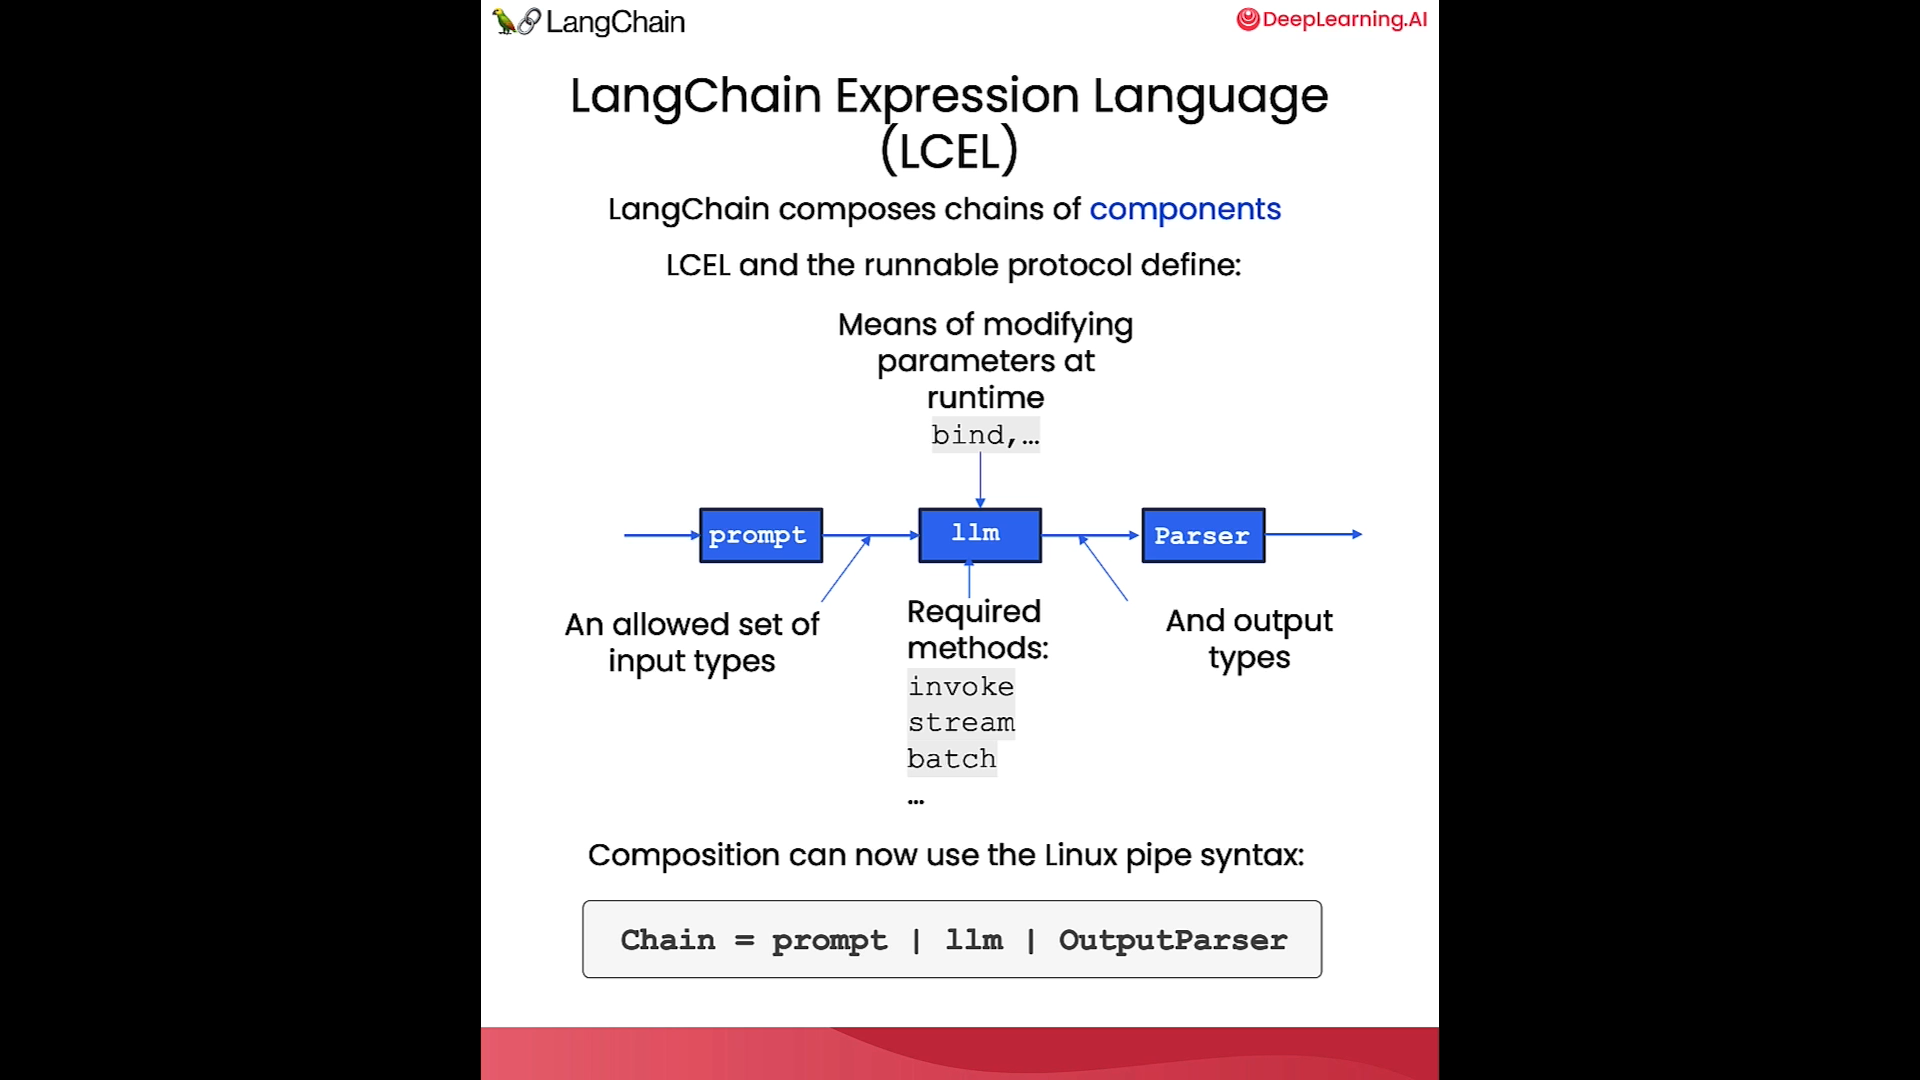

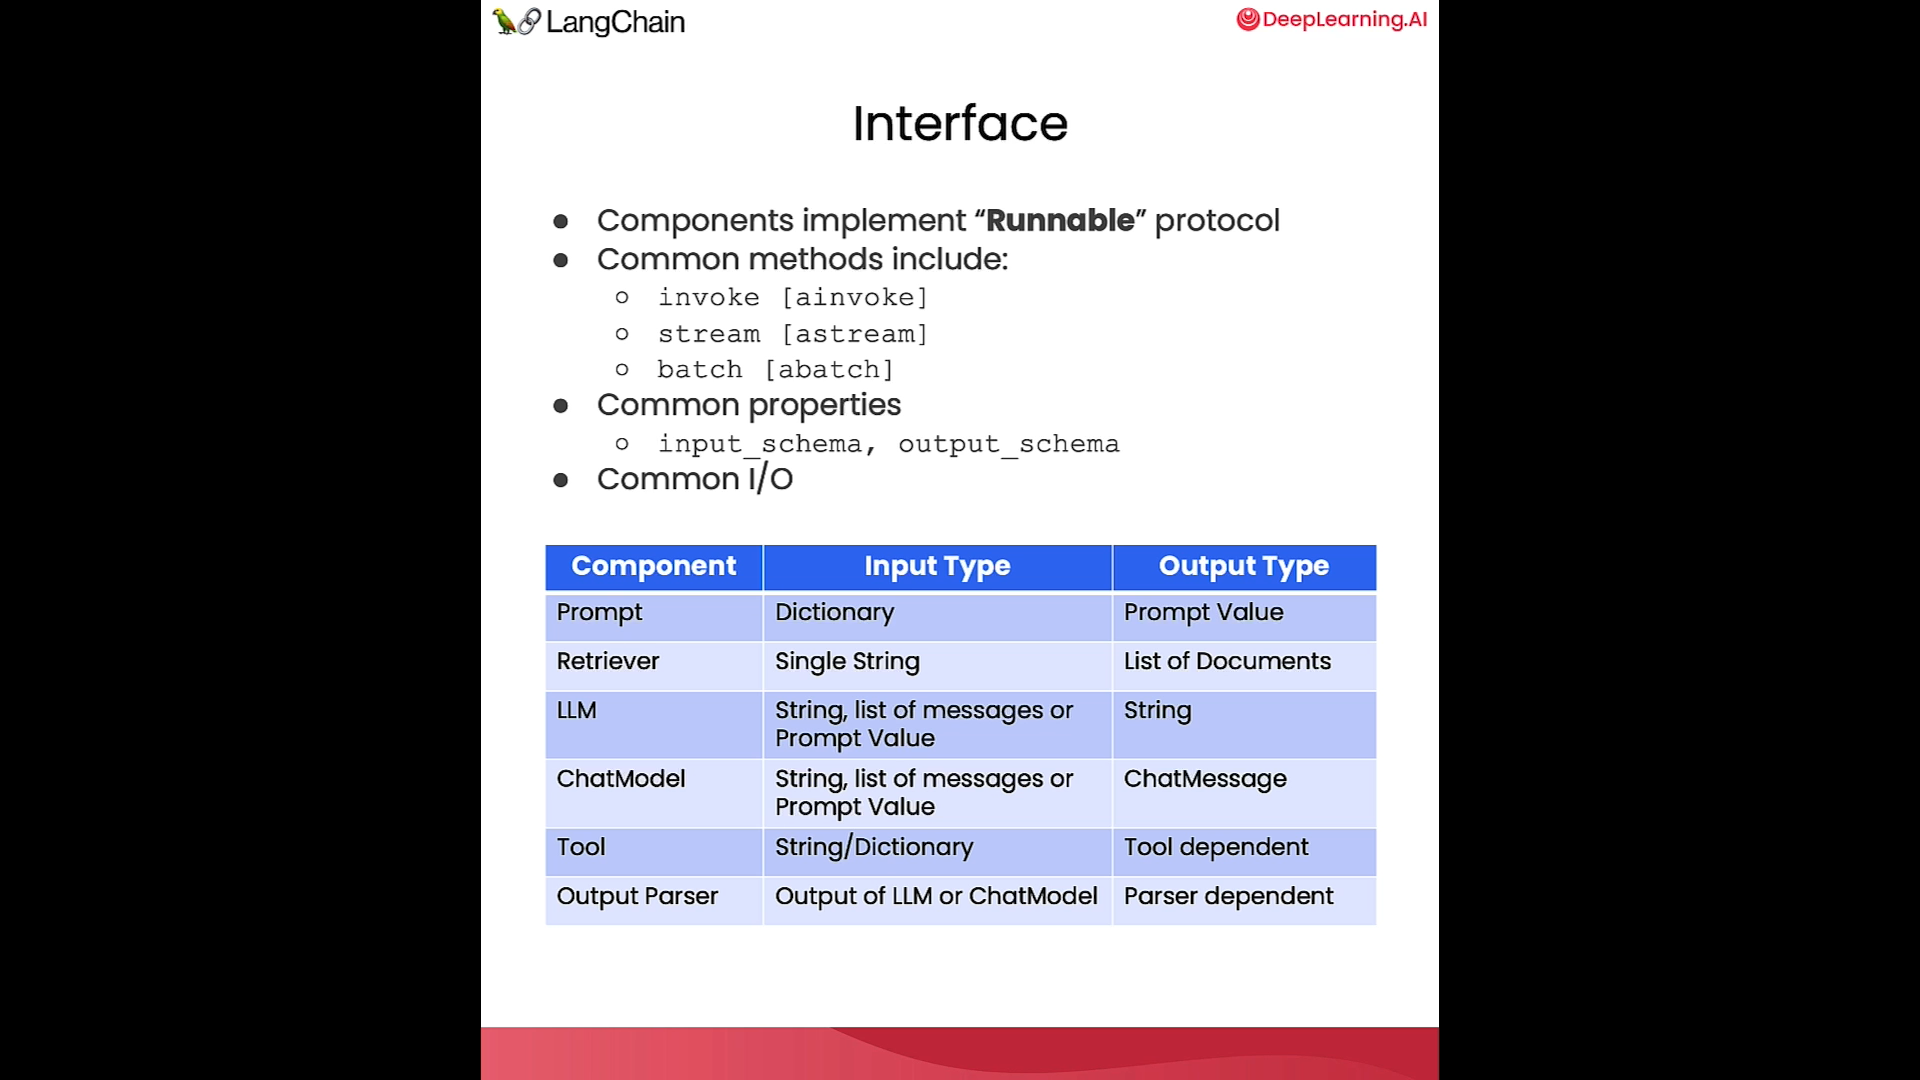

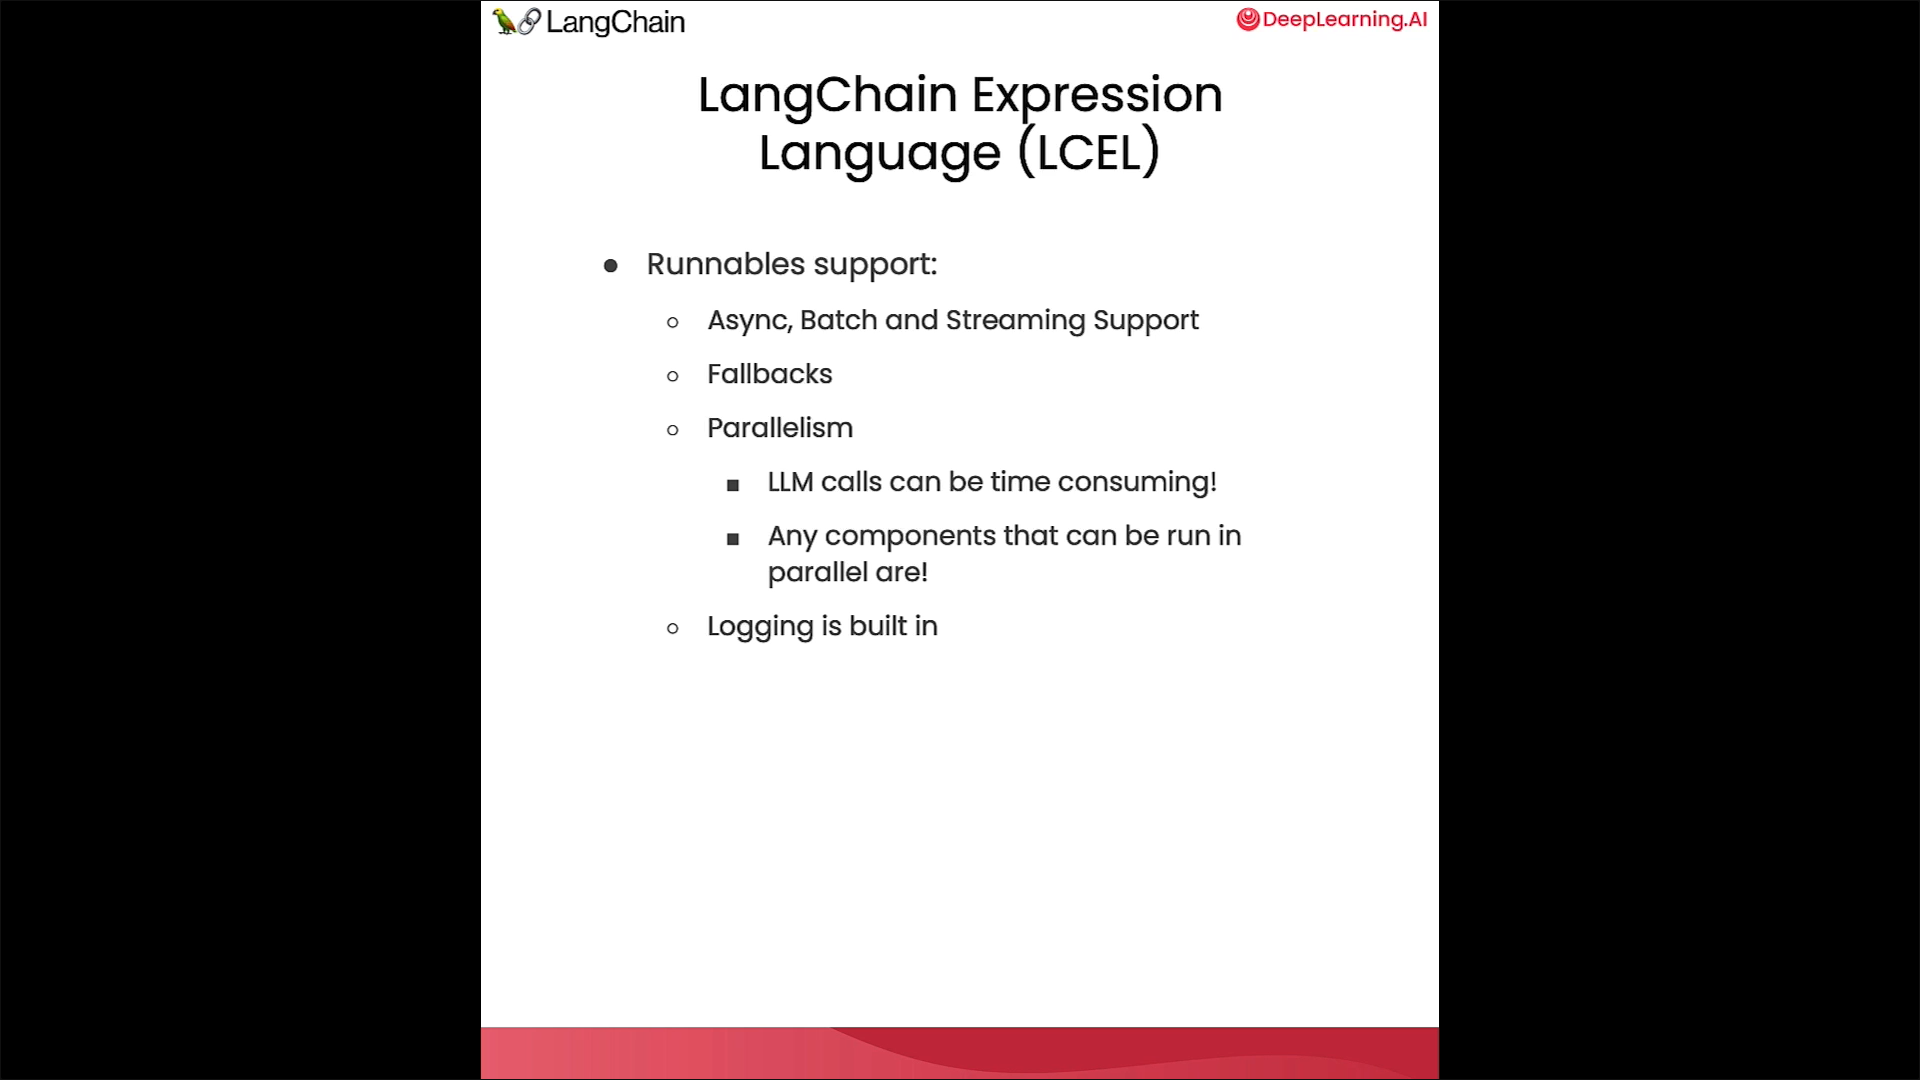

In [1]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
#!pip install pydantic==1.10.8

In [4]:
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser ## Converting chat message to string

## Simple Chain

In [5]:
prompt = ChatPromptTemplate.from_template(
    "tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

In [6]:
chain = prompt | model | output_parser

In [7]:
chain.invoke({"topic": "bears"})

"Why don't bears like fast food? Because they can't catch it!"

## More complex chain

And Runnable Map to supply user-provided inputs to the prompt.

In [8]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch

In [9]:
vectorstore = DocArrayInMemorySearch.from_texts(
    ["harrison worked at kensho", "bears like to eat honey"],
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [10]:
retriever.get_relevant_documents("where did harrison work?")

[Document(page_content='harrison worked at kensho'),
 Document(page_content='bears like to eat honey')]

In [11]:
retriever.get_relevant_documents("what do bears like to eat")

[Document(page_content='bears like to eat honey'),
 Document(page_content='harrison worked at kensho')]

In [12]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [13]:
from langchain.schema.runnable import RunnableMap

In [14]:
chain = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
}) | prompt | model | output_parser

In [15]:
chain.invoke({"question": "where did harrison work?"})

'Harrison worked at Kensho.'

In [16]:
inputs = RunnableMap({
    "context": lambda x: retriever.get_relevant_documents(x["question"]),
    "question": lambda x: x["question"]
})

In [17]:
inputs.invoke({"question": "where did harrison work?"})

{'context': [Document(page_content='harrison worked at kensho'),
  Document(page_content='bears like to eat honey')],
 'question': 'where did harrison work?'}

## Bind

and OpenAI Functions

In [18]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    }
  ]

In [19]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}")
    ]
)
model = ChatOpenAI(temperature=0).bind(functions=functions) ## CALLING Function by using bind

In [20]:
runnable = prompt | model

In [21]:
runnable.invoke({"input": "what is the weather in sf"})

AIMessage(content='', additional_kwargs={'function_call': {'name': 'weather_search', 'arguments': '{\n  "airport_code": "SFO"\n}'}})

In [22]:
functions = [
    {
      "name": "weather_search",
      "description": "Search for weather given an airport code",
      "parameters": {
        "type": "object",
        "properties": {
          "airport_code": {
            "type": "string",
            "description": "The airport code to get the weather for"
          },
        },
        "required": ["airport_code"]
      }
    },
        {
      "name": "sports_search",
      "description": "Search for news of recent sport events",
      "parameters": {
        "type": "object",
        "properties": {
          "team_name": {
            "type": "string",
            "description": "The sports team to search for"
          },
        },
        "required": ["team_name"]
      }
    }
  ]

In [23]:
model = model.bind(functions=functions)

In [24]:
runnable = prompt | model

In [25]:
runnable.invoke({"input": "how did the patriots do yesterday?"})

AIMessage(content='', additional_kwargs={'function_call': {'name': 'sports_search', 'arguments': '{\n  "team_name": "patriots"\n}'}})

## Fallbacks

In [26]:
from langchain.llms import OpenAI
import json

**Note**: Due to the deprecation of OpenAI's model `text-davinci-001` on 4 January 2024, you'll be using OpenAI's recommended replacement model `gpt-3.5-turbo-instruct` instead.

In [27]:
simple_model = OpenAI(
    temperature=0, 
    max_tokens=1000, 
    model="gpt-3.5-turbo-instruct"
)
simple_chain = simple_model | json.loads ## This will break if json is not valid

In [28]:
challenge = "write three poems in a json blob, where each poem is a json blob of a title, author, and first line"

In [29]:
simple_model.invoke(challenge)

'\n\n{\n    "title": "Autumn Leaves",\n    "author": "Emily Dickinson",\n    "first_line": "The leaves are falling, one by one"\n}\n\n{\n    "title": "The Ocean\'s Song",\n    "author": "Pablo Neruda",\n    "first_line": "I hear the ocean\'s song, a symphony of waves"\n}\n\n{\n    "title": "A Winter\'s Night",\n    "author": "Robert Frost",\n    "first_line": "The snow falls softly, covering the ground"\n}'

**Note**: The next line is expected to fail.

In [30]:
simple_chain.invoke(challenge)

JSONDecodeError: Extra data: line 9 column 1 (char 125)

In [31]:
model = ChatOpenAI(temperature=0)
chain = model | StrOutputParser() | json.loads

In [32]:
chain.invoke(challenge)

{'poem1': {'title': 'Whispers of the Wind',
  'author': 'Emily Rivers',
  'first_line': 'In the stillness of night, whispers of the wind'},
 'poem2': {'title': 'Silent Tears',
  'author': 'Jacob Anderson',
  'first_line': 'Silent tears fall, unseen by the world'},
 'poem3': {'title': 'Dancing Shadows',
  'author': 'Sophia Lee',
  'first_line': 'Beneath the moonlight, dancing shadows sway'}}

In [33]:
final_chain = simple_chain.with_fallbacks([chain]) ## if simiple chain fails then above chain will be called

In [34]:
final_chain.invoke(challenge)

{'poem1': {'title': 'Whispers of the Wind',
  'author': 'Emily Rivers',
  'first_line': 'Softly it comes, the whisper of the wind'},
 'poem2': {'title': 'Silent Serenade',
  'author': 'Jacob Moore',
  'first_line': 'In the stillness of night, a silent serenade'},
 'poem3': {'title': 'Dancing Shadows',
  'author': 'Sophia Anderson',
  'first_line': 'Shadows dance upon the moonlit floor'}}

## Interface

In [35]:
prompt = ChatPromptTemplate.from_template(
    "Tell me a short joke about {topic}"
)
model = ChatOpenAI()
output_parser = StrOutputParser()

chain = prompt | model | output_parser

In [36]:
chain.invoke({"topic": "bears"})

"Why don't bears wear shoes?\n\nBecause they have bear feet!"

In [37]:
chain.batch([{"topic": "bears"}, {"topic": "frogs"}])

["Why don't bears wear shoes?\n\nBecause they like to go bear-foot!",
 'Why don\'t frogs like to play basketball?\n\nBecause they\'re afraid of getting called for "hopping" fouls!']

In [39]:
for t in chain.stream({"topic": "bears"}):
    print(t)

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIError: HTTP code 500 from API (500 error
).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIError: HTTP code 500 from API (500 error
).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised APIError: HTTP code 500 from API (500 error
).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 8.0 seconds as it raised APIError: HTTP code 500 from API (500 error
).
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 10.0 seconds as it raised APIError: HTTP code 500 from API (500 error
).


APIError: HTTP code 500 from API (500 error
)

In [ ]:
response = await chain.ainvoke({"topic": "bears"})
response